In [1]:
#データをトレーニング・テストに分けるモジュール
from sklearn.model_selection import train_test_split
#ロジスティック回帰モデル
from sklearn.linear_model import LogisticRegression
#正答率算出
from sklearn.metrics import accuracy_score
#category encoder インポート
import category_encoders as ce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#欠損埋めモジュール
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import missingno as mno

########################
#サンプルデータ  準備
#Adult Data Set
########################
df_adult = pd.read_csv('adult.data', header=None)
#変数名付与
df_adult.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum", "MaritalStatus",
    "Occupation", "Relationship", "Race", "Gender", "CapitalGain",
    "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

#欠損率を20%と設定
p = 0.2
#架空の欠損データ生成
from numpy.random import *
seed(1)
x = pd.Series(np.random.uniform(0.0, 1.0, len(df_adult)))
x.index = df_adult.index

#MCAR作成
df_adult['Age_mcar'] = np.where(x < p, np.nan, df_adult['Age'])

#MAR作成
#全体の欠損率が20%、女性の欠損率が30%となるように設定
p_f = 0.3
p_m = (round(len(df_adult) * p) - df_adult.Gender.value_counts()[1] * p_f
       ) / df_adult.Gender.value_counts()[0]

#男性
ix = df_adult['Gender'] == ' Male'
seed(2)
x = pd.Series(np.random.uniform(0.0, 1.0, len(df_adult)))
x.index = df_adult.index
df_adult['Age_mar'] = np.where((x < p_m) & (ix), np.nan, df_adult['Age'])

#女性
ix = df_adult['Gender'] == ' Male'
seed(3)
x = pd.Series(np.random.uniform(0.0, 1.0, len(df_adult)))
x.index = df_adult.index
df_adult['Age_mar'] = np.where((x < p_f) & (~ix), np.nan, df_adult['Age_mar'])

#MNAR
#40歳以上の一部を欠損とする
ix = df_adult['Age'] >= 40
p_40 = round(len(df_adult) * p) / (ix).sum()
seed(4)
x = pd.Series(np.random.uniform(0.0, 1.0, len(df_adult)))
x.index = df_adult.index
#30%欠損
df_adult['Age_mnar'] = np.where((x < p_40) & (ix), np.nan, df_adult['Age'])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#ターゲット変数1/0エンコーディング
df_adult['Income'] = (df_adult['Income'] == ' >50K').astype(int)
#特徴量取得
X_adult = df_adult.drop(['Income'], axis=1)
#ターゲット変数を取得
y_adult = df_adult['Income']
#訓練・検証データを分離
X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(
    X_adult, y_adult, test_size=0.2, random_state=1)

#ターゲットエンコーダ インスタンス化
encoder = ce.TargetEncoder(cols=['Education', 'Occupation', 'NativeCountry'])
enc = encoder.fit(X_adult_train, y_adult_train)
X_adult_train = enc.transform(X_adult_train)
X_adult_test = enc.transform(X_adult_test)

#One-Hotエンコーディング インスタンス化
encoder = ce.OneHotEncoder(
    cols=['WorkClass', 'MaritalStatus', 'Relationship', 'Race', 'Gender'],
    use_cat_names=True)
enc = encoder.fit(X_adult_train)
X_adult_train = enc.transform(X_adult_train)
X_adult_test = enc.transform(X_adult_test)

#One-Hotで冗長になった変数を落とす
drop_l = [
    [col for col in X_adult_train.columns if col.find('WorkClass') >= 0][0], [
        col for col in X_adult_train.columns if col.find('MaritalStatus') >= 0
    ][0], [
        col for col in X_adult_train.columns if col.find('Relationship') >= 0
    ][0], [col for col in X_adult_train.columns if col.find('Race') >= 0][0],
    [col for col in X_adult_train.columns if col.find('Gender') >= 0][0]
]
X_adult_train = X_adult_train.drop(drop_l, axis=1)
X_adult_test = X_adult_test.drop(drop_l, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [3]:
# 欠損を含むカラムがあるか確認
print(df_adult.isnull().any())

Age              False
WorkClass        False
fnlwgt           False
Education        False
EducationNum     False
MaritalStatus    False
Occupation       False
Relationship     False
Race             False
Gender           False
CapitalGain      False
CapitalLoss      False
HoursPerWeek     False
NativeCountry    False
Income           False
Age_mcar          True
Age_mar           True
Age_mnar          True
dtype: bool


In [4]:
# カラムごとの欠損の個数を確認
print(df_adult.isnull().sum())

Age                 0
WorkClass           0
fnlwgt              0
Education           0
EducationNum        0
MaritalStatus       0
Occupation          0
Relationship        0
Race                0
Gender              0
CapitalGain         0
CapitalLoss         0
HoursPerWeek        0
NativeCountry       0
Income              0
Age_mcar         6534
Age_mar          6623
Age_mnar         6612
dtype: int64


<AxesSubplot:>

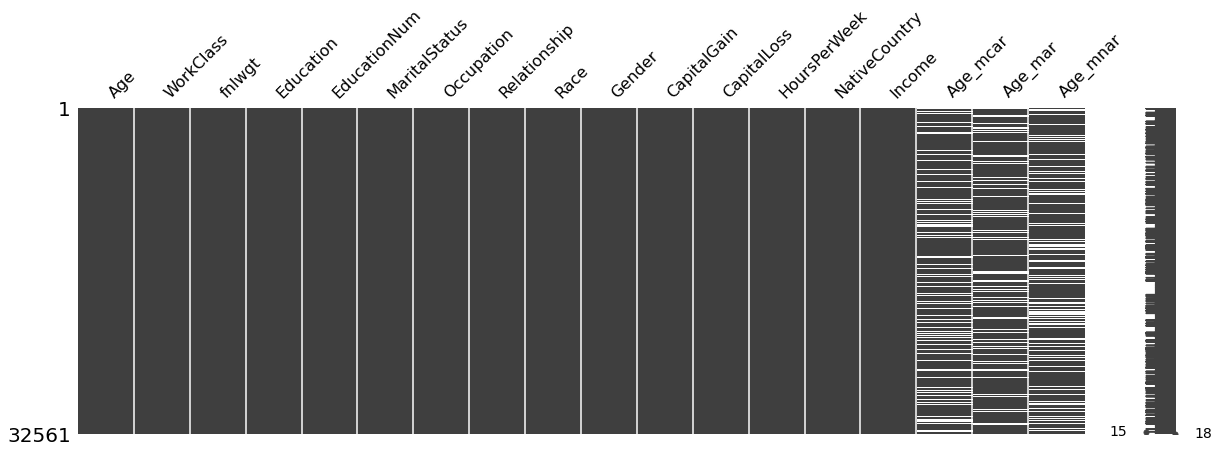

In [5]:
mno.matrix(df_adult, figsize = (20, 6))

In [6]:
#欠損を含む行及び列を落とす (例としてMCARの場合)
#データ作成
X_adult_train_mcar = X_adult_train.drop(['Age','Age_mar','Age_mnar'],axis=1)
print (X_adult_train_mcar.isnull().sum())

#行を落とす
X_adult_train_mcar_dropnar = X_adult_train_mcar.dropna()
print (X_adult_train_mcar_dropnar.isnull().sum())

#列を落とす(axis=1オプション)
X_adult_train_mcar_dropnac = X_adult_train_mcar.dropna(axis=1)
print (X_adult_train_mcar_dropnac.isnull().sum())

WorkClass_ Private                         0
WorkClass_ State-gov                       0
WorkClass_ ?                               0
WorkClass_ Federal-gov                     0
WorkClass_ Local-gov                       0
WorkClass_ Self-emp-inc                    0
WorkClass_ Never-worked                    0
WorkClass_ Without-pay                     0
fnlwgt                                     0
Education                                  0
EducationNum                               0
MaritalStatus_ Never-married               0
MaritalStatus_ Divorced                    0
MaritalStatus_ Widowed                     0
MaritalStatus_ Married-spouse-absent       0
MaritalStatus_ Separated                   0
MaritalStatus_ Married-AF-spouse           0
Occupation                                 0
Relationship_ Not-in-family                0
Relationship_ Other-relative               0
Relationship_ Unmarried                    0
Relationship_ Own-child                    0
Relationsh

In [7]:
#元のデータを消さないように
X_adult_train_fillna = X_adult_train.copy()
X_adult_test_fillna = X_adult_test.copy()

#平均値で埋める
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
missing_cols = ['Age_mcar', 'Age_mar', 'Age_mnar']
#訓練データから平均値を算出
imputer.fit(X_adult_train_fillna[missing_cols])
#訓練データ
X_adult_train_fillna[[col + '_mean' for col in missing_cols]] = pd.DataFrame(
    imputer.transform(X_adult_train_fillna[missing_cols]),
    index=X_adult_train.index)
#テストデータ
X_adult_test_fillna[[col + '_mean' for col in missing_cols]] = pd.DataFrame(
    imputer.transform(X_adult_test_fillna[missing_cols]),
    index=X_adult_test.index)

#中央値で埋める
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
missing_cols = ['Age_mcar', 'Age_mar', 'Age_mnar']
imputer.fit(X_adult_train_fillna[missing_cols])
imputer.fit(X_adult_train_fillna[missing_cols])
#訓練データ
X_adult_train_fillna[[col + '_median' for col in missing_cols]] = pd.DataFrame(
    imputer.transform(X_adult_train_fillna[missing_cols]),
    index=X_adult_train.index)
#テストデータ
X_adult_test_fillna[[col + '_median' for col in missing_cols]] = pd.DataFrame(
    imputer.transform(X_adult_test_fillna[missing_cols]),
    index=X_adult_test.index)

#最頻値で埋める
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
missing_cols = ['Age_mcar', 'Age_mar', 'Age_mnar']
imputer.fit(X_adult_train_fillna[missing_cols])
#訓練データ
X_adult_train_fillna[[col + '_mode' for col in missing_cols]] = pd.DataFrame(
    imputer.transform(X_adult_train_fillna[missing_cols]),
    index=X_adult_train.index)
#テストデータ
X_adult_test_fillna[[col + '_mode' for col in missing_cols]] = pd.DataFrame(
    imputer.transform(X_adult_test_fillna[missing_cols]),
    index=X_adult_test.index)

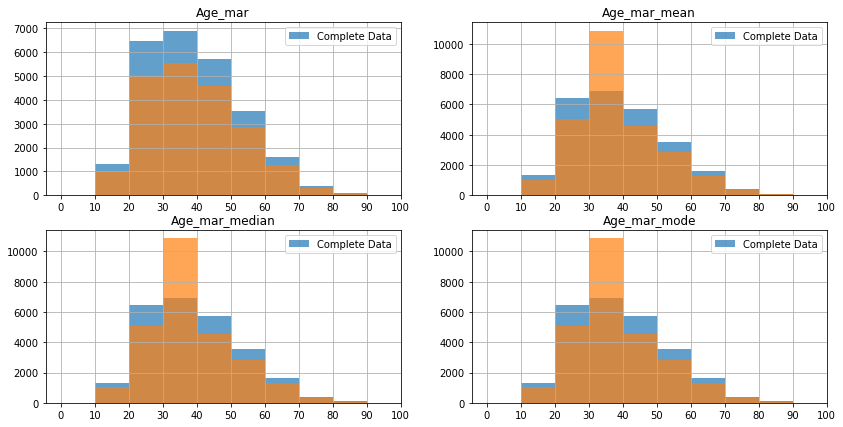

In [8]:
#MARの代入前後の分布
plt.figure(figsize=(14, 7))
for i, col in enumerate(
    ['Age_mar', 'Age_mar_mean', 'Age_mar_median', 'Age_mar_mode']):
    plt.subplot(2, 2, i + 1)
    plt.hist(
        X_adult_train_fillna['Age'],
        alpha=0.7,
        label='Complete Data',
        bins=range(0, 100, 10))
    plt.legend()
    plt.hist(X_adult_train_fillna[col], alpha=0.7, bins=range(0, 100, 10))
    plt.grid()
    plt.title(col)
    plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [9]:
#欠損値推測
#sklearnのLinearRegressionモジュール読み込む
from sklearn.linear_model import LinearRegression
#線形回帰のインスタンス化
reg1 = LinearRegression()
reg2 = LinearRegression()
reg3 = LinearRegression()

#MCARに対して処理を実行
#使用しない特徴量のリスト特にターゲットエンコーディングした特徴量は除く
ix = X_adult_train['Age_mcar'].isnull()
drop = ['Education', 'Occupation', 'NativeCountry'
        ] + ['Age', 'Age_mcar', 'Age_mar', 'Age_mnar', 'fnlwgt']
x1 = X_adult_train[~ix].drop(drop, axis=1)
x2 = X_adult_train.loc[x1.index, 'Age_mcar']

#線形回帰
reg1.fit(x1, x2)

#訓練データ予測する
X_adult_train_fillna['Age_mcar_reg'] = pd.Series(
    reg1.predict(X_adult_train[ix].drop(drop, axis=1)),
    X_adult_train[ix].index)
X_adult_train_fillna['Age_mcar_reg'] = X_adult_train_fillna[
    'Age_mcar_reg'].fillna(X_adult_train_fillna['Age'])
#検証データ予測する
ixt = X_adult_test['Age_mcar'].isnull()
X_adult_test_fillna['Age_mcar_reg'] = pd.Series(
    reg1.predict(X_adult_test[ixt].drop(drop, axis=1)),
    X_adult_test[ixt].index)
X_adult_test_fillna['Age_mcar_reg'] = X_adult_test_fillna[
    'Age_mcar_reg'].fillna(X_adult_test_fillna['Age'])

In [11]:
#MARに対して処理を実行
#使用しない特徴量のリスト特にターゲットエンコーディングした特徴量は除く
ix = X_adult_train['Age_mar'].isnull()
drop = ['Education', 'Occupation', 'NativeCountry'
        ] + ['Age', 'Age_mcar', 'Age_mar', 'Age_mnar', 'fnlwgt']
x1 = X_adult_train[~ix].drop(drop, axis=1)
x2 = X_adult_train.loc[x1.index, 'Age_mar']

#線形回帰
reg2.fit(x1, x2)

#訓練データ予測する
X_adult_train_fillna['Age_mar_reg'] = pd.Series(
    reg2.predict(X_adult_train[ix].drop(drop, axis=1)),
    X_adult_train[ix].index)
X_adult_train_fillna['Age_mar_reg'] = X_adult_train_fillna[
    'Age_mar_reg'].fillna(X_adult_train_fillna['Age'])
#検証データ予測する
ixt = X_adult_test['Age_mar'].isnull()
X_adult_test_fillna['Age_mar_reg'] = pd.Series(
    reg1.predict(X_adult_test[ixt].drop(drop, axis=1)),
    X_adult_test[ixt].index)
X_adult_test_fillna['Age_mar_reg'] = X_adult_test_fillna['Age_mar_reg'].fillna(
    X_adult_test_fillna['Age'])

#MNARに対して処理を実行
#使用しない特徴量のリスト特にターゲットエンコーディングした特徴量は除く
ix = X_adult_train['Age_mnar'].isnull()
drop = ['Education', 'Occupation', 'NativeCountry'
        ] + ['Age', 'Age_mcar', 'Age_mar', 'Age_mnar', 'fnlwgt']
x1 = X_adult_train[~ix].drop(drop, axis=1)
x2 = X_adult_train.loc[x1.index, 'Age_mnar']
#線形回帰
reg3.fit(x1, x2)

#訓練データ予測する
X_adult_train_fillna['Age_mnar_reg'] = pd.Series(
    reg3.predict(X_adult_train[ix].drop(drop, axis=1)),
    X_adult_train[ix].index)
X_adult_train_fillna['Age_mnar_reg'] = X_adult_train_fillna[
    'Age_mnar_reg'].fillna(X_adult_train_fillna['Age'])
#検証データ予測する
ixt = X_adult_test['Age_mnar'].isnull()
X_adult_test_fillna['Age_mnar_reg'] = pd.Series(
    reg1.predict(X_adult_test[ixt].drop(drop, axis=1)),
    X_adult_test[ixt].index)
X_adult_test_fillna['Age_mnar_reg'] = X_adult_test_fillna[
    'Age_mnar_reg'].fillna(X_adult_test_fillna['Age'])

In [12]:
##################MCAR 埋める##################
#使用しない特徴量のリスト特にターゲットエンコーディングした特徴量は除く
drop = ['Education', 'Occupation', 'NativeCountry'
        ] + ['Age', 'Age_mar', 'Age_mnar', 'fnlwgt']

#KNNImputerインスタンス化
imputer = KNNImputer(n_neighbors=2)
#訓練
imputer.fit(X_adult_train.drop(drop, axis=1))
#訓練データに代入
X_adult_train_fillna['Age_mcar_knn'] = pd.DataFrame(
    imputer.transform(X_adult_train.drop(drop, axis=1)),
    index=X_adult_train.drop(drop, axis=1).index,
    columns=X_adult_train.drop(drop, axis=1).columns)['Age_mcar']

#検証データに代入
X_adult_test_fillna['Age_mcar_knn'] = pd.DataFrame(
    imputer.transform(X_adult_test.drop(drop, axis=1)),
    index=X_adult_test.drop(drop, axis=1).index,
    columns=X_adult_test.drop(drop, axis=1).columns)['Age_mcar']

##################MAR 埋める##################
#使用しない特徴量のリスト特にターゲットエンコーディングした特徴量は除く
drop = ['Education', 'Occupation', 'NativeCountry'
        ] + ['Age', 'Age_mcar', 'Age_mnar', 'fnlwgt']

#KNNImputerインスタンス化
imputer = KNNImputer(n_neighbors=2)
#訓練
imputer.fit(X_adult_train.drop(drop, axis=1))
#訓練データに代入
X_adult_train_fillna['Age_mar_knn'] = pd.DataFrame(
    imputer.transform(X_adult_train.drop(drop, axis=1)),
    index=X_adult_train.drop(drop, axis=1).index,
    columns=X_adult_train.drop(drop, axis=1).columns)['Age_mar']

#検証データに代入
X_adult_test_fillna['Age_mar_knn'] = pd.DataFrame(
    imputer.transform(X_adult_test.drop(drop, axis=1)),
    index=X_adult_test.drop(drop, axis=1).index,
    columns=X_adult_test.drop(drop, axis=1).columns)['Age_mar']

 ##################MNAR 埋める##################
#使用しない特徴量のリスト特にターゲットエンコーディングした特徴量は除く
drop = ['Education', 'Occupation', 'NativeCountry'
        ] + ['Age', 'Age_mcar', 'Age_mar', 'fnlwgt']

#KNNImputerインスタンス化
imputer = KNNImputer(n_neighbors=2)
#訓練
imputer.fit(X_adult_train.drop(drop, axis=1))
#訓練データに代入
X_adult_train_fillna['Age_mnar_knn'] = pd.DataFrame(
    imputer.transform(X_adult_train.drop(drop, axis=1)),
    index=X_adult_train.drop(drop, axis=1).index,
    columns=X_adult_train.drop(drop, axis=1).columns)['Age_mnar']

#検証データに代入
X_adult_test_fillna['Age_mnar_knn'] = pd.DataFrame(
    imputer.transform(X_adult_test.drop(drop, axis=1)),
    index=X_adult_test.drop(drop, axis=1).index,
    columns=X_adult_test.drop(drop, axis=1).columns)['Age_mnar']

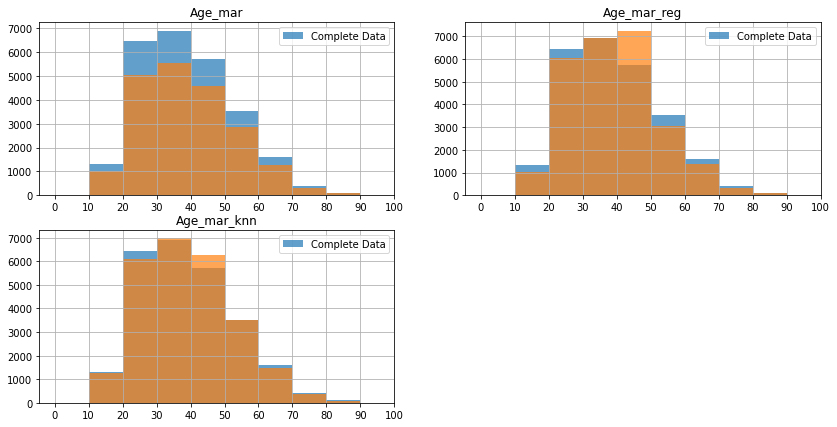

In [13]:
#MARの代入前後の分布
plt.figure(figsize=(14, 7))
for i, col in enumerate(['Age_mar', 'Age_mar_reg', 'Age_mar_knn']):
    plt.subplot(2, 2, i + 1)
    plt.hist(
        X_adult_train_fillna['Age'],
        alpha=0.7,
        label='Complete Data',
        bins=range(0, 100, 10))
    plt.legend()
    plt.hist(X_adult_train_fillna[col], alpha=0.7, bins=range(0, 100, 10))
    plt.grid()
    plt.title(col)
    plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])